# MNIST Example

This minimal-example notebook allows you to interact with ITS without any unnecessary bells and whistles.
Please, keep in mind that the idea of ITS is *not* to outperform SOTA methods on robustness nor equivariant models.
Instead our aim is to show what vanilla classifiers are able to do on (OOD) transformed test sets.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.chdir("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# fix seed
torch.manual_seed(1234)
np.random.seed(1234)

cuda


## Load the (vanilla) dataset

This is the usual code to load either MNIST or Fashion-MNIST with a train-val-test split.
As we do not restrict the possible rotation angles (later on), we exclude all MNIST samples with label `9`.
They get indistinguishable under `180` degree rotations from a `6`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


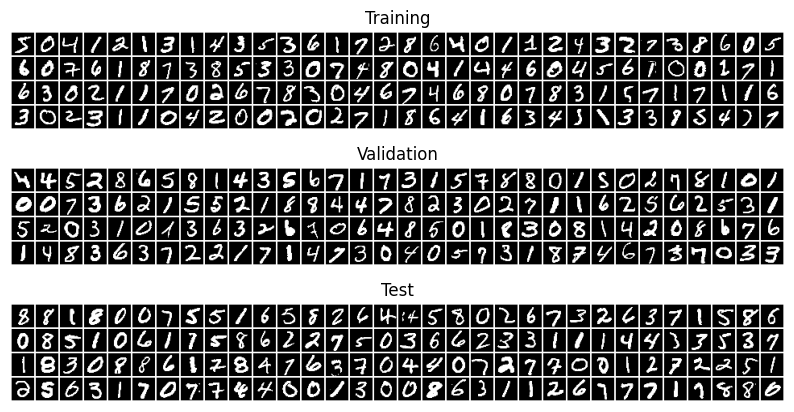

In [2]:
dataset = 'mnist' # or 'fmnist'
batch_size = 128

if dataset == 'mnist':
    # essentially excluding either 6 or 9 as these would cause degenerations under 180 degree rotation
    from src.data import load_mnist
    n_classes = 9
    test_val_split = [5000, 3991]
    train_set = load_mnist(test_set=False)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=4)
    test_set = load_mnist(test_set=True)

elif dataset == 'fmnist':
    n_classes = 10
    test_val_split = [5000, 5000]
    train_set = torchvision.datasets.FashionMNIST('./data/', train=True, download=True, transform=torchvision.transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=4)
    test_set = torchvision.datasets.FashionMNIST('./data/', train=False, download=True, transform=torchvision.transforms.ToTensor())
else:
    raise ValueError('Choose either `mnist` or `fmnist`.')

test_set, val_set = torch.utils.data.random_split(test_set, test_val_split)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
    
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5))

axs[0].imshow(torchvision.utils.make_grid(next(iter(train_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[1].imshow(torchvision.utils.make_grid(next(iter(val_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[2].imshow(torchvision.utils.make_grid(next(iter(test_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[2].set_title('Test')

for ax in axs.flat:
    ax.axis('off')

# Transform the test set

This cell transforms `only` the test set. Here, we used random `rotations` in $[\pi, \pi]$ and random `scaling` in $[-0.5, 0.5]$.
You can use any (reasonable) range and any of the supported affine transformation (including `translation` and `shearing`).
This list will be extended over time. Also note that, as the search does not need to be differentiable, in theory any transformation can be used.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421302..2.821487].


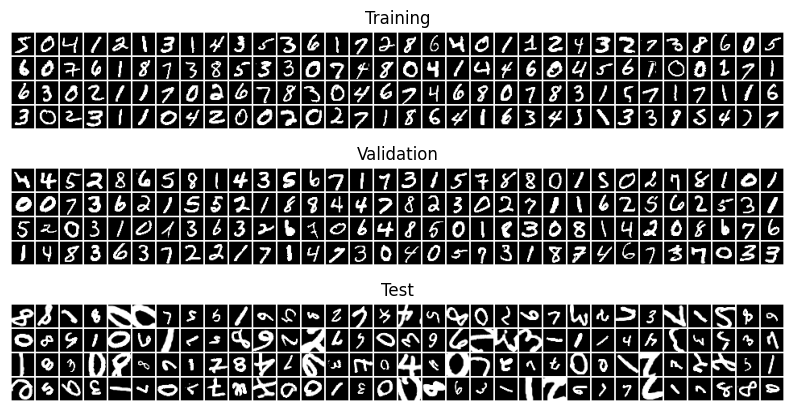

In [3]:
from src.transform import AffineTransformation, multi_transform
from src.data import TransformDataLoader

transformations = [AffineTransformation.ROTATION.value, AffineTransformation.SCALING.value]
domains = [(torch.pi,), (0.5,)]
n_samples = 9

def transform(data):
    x, y = data
    n = torch.randint(0, n_samples, (x.shape[0], len(transformations)), device=x.device)
    x, _, _ = multi_transform(x, transformations, n, n_samples=n_samples, domain=domains)
    return x, y

test_loader = TransformDataLoader(test_loader, transform)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5))

axs[0].imshow(torchvision.utils.make_grid(next(iter(train_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[1].imshow(torchvision.utils.make_grid(next(iter(val_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[2].imshow(torchvision.utils.make_grid(next(iter(test_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[2].set_title('Test')

for ax in axs.flat:
    ax.axis('off')

## Instantiate the model

We use a simple ConvNet. You can replace this by any architecture as long as ITS can access the logits. See `_predict` in `InverseTransformationSearch` in [search.py](../src/search.py). Here the model is called and the response is assumed to be the logits. If you use a model from huggingface with a softmax head, you need to add a hotfix into that routine, like `return self.model(x).embeddings`.

In [4]:
class ConvNet(nn.Module):
    def __init__(self, n_classes=9):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5)
        self.fc1 = nn.Linear(3*3*16, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.gelu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size()[0], -1)
        x = F.gelu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.5)
        return self.fc2(x)

model = ConvNet(n_classes=n_classes).to(device)
print(model(torch.zeros(batch_size, 1, 28, 28).to(device)).shape)

torch.Size([128, 9])


## Train the model (or load it)

In [5]:
optimiser = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=2e-2)

pbar = tqdm(range(3))
for e in pbar:
    
    model.train()
    train_acc = 0
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        optimiser.zero_grad()
        output = model(data)
        output = F.log_softmax(output, dim=-1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimiser.step()
        train_acc += output.argmax(dim=-1).eq(target).sum().item()
    train_acc /= len(train_set)
    
    model.eval()
    val_acc = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        val_acc += output.argmax(dim=-1).eq(target).sum().item()
    val_acc /= len(val_set)
    
    pbar.set_description(f'Epoch {e} | Train acc@1: {train_acc:.4f} | Validation acc@1: {val_acc:.4f}')
    
with torch.no_grad():
    traced_cell = torch.jit.trace(model, (data))
torch.jit.save(traced_cell, f'./model/{dataset}.pth')

Epoch 2 | Train acc@1: 0.9688 | Validation acc@1: 0.9912: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.32s/it]


## Evaluation on (transformed) test set

First, we obtain the baseline performance on the transformed test set by issuing the classifier without ITS.

In [6]:
model.eval()
test_acc = 0
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    test_acc += output.argmax(dim=-1).eq(target).sum().item()
test_acc /= len(test_set)
print(f'Mean accuracy on the transformed test set: {test_acc}.')

Mean accuracy on the transformed test set: 0.3716.


## Same test with ITS
To use ITS, you first initialise it by setting the classifier and some hyper-parameters to `InverseTransformationSearch`.
Afterwards, you can use it during inference to canonicalise inputs by issuing `canonical_x, model_embeddings = its.infer(x)` (where the embeddings are your model's response to the canonicalised input).

- When setting the Monte-Carlo simulations to `mc_steps=1` a deterministic confidence surface is obtained. Every other component of the confidence estimation is deterministic (e.g., the model is frozen) and stochasticity is only introduced by the MC steps. Increasing `mc_steps>1` results in confidences for identity elements to change over the search.

- Letting `en_unique_class_condition=True` ensures that each hypothesis follows a candidate with an unique class label. With other words, they are mutually exclusive. The idea is to avoid over-confidence for initial class-hypotheses, where all hypotheses start developing equally-labeled samples. By enabling this condition the exploration is increased.

- The number of samples per search level `n_samples>0` can be set to any (reasonable) positive integer value. We recommend using odd values. This ensures that the identity is included in the sample list.

- The number of hypotheses (i.e., the number of branches) `n_hypotheses>1` can also be set freely. We suggest some value between `[1,5]`.

- Change of mind (`change_of_mind`) can be turned `off` which would use the initial order of hypotheses (determined in the very first level). Currently we only support one alternative, which is called `score`. This would activate the change of mind by re-ordering the hypotheses ranks at the end of the search given the accumulated score values of each branch. 

Calling `its.infer` with a `plot_idx` plots the search results of this batch index.

/project/johannsc/symmetries/ITS/src/search.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -curvature(torch.tensor(energies, device=z.device))


Mean accuracy on the transformed test set [but with ITS]: 0.7594.


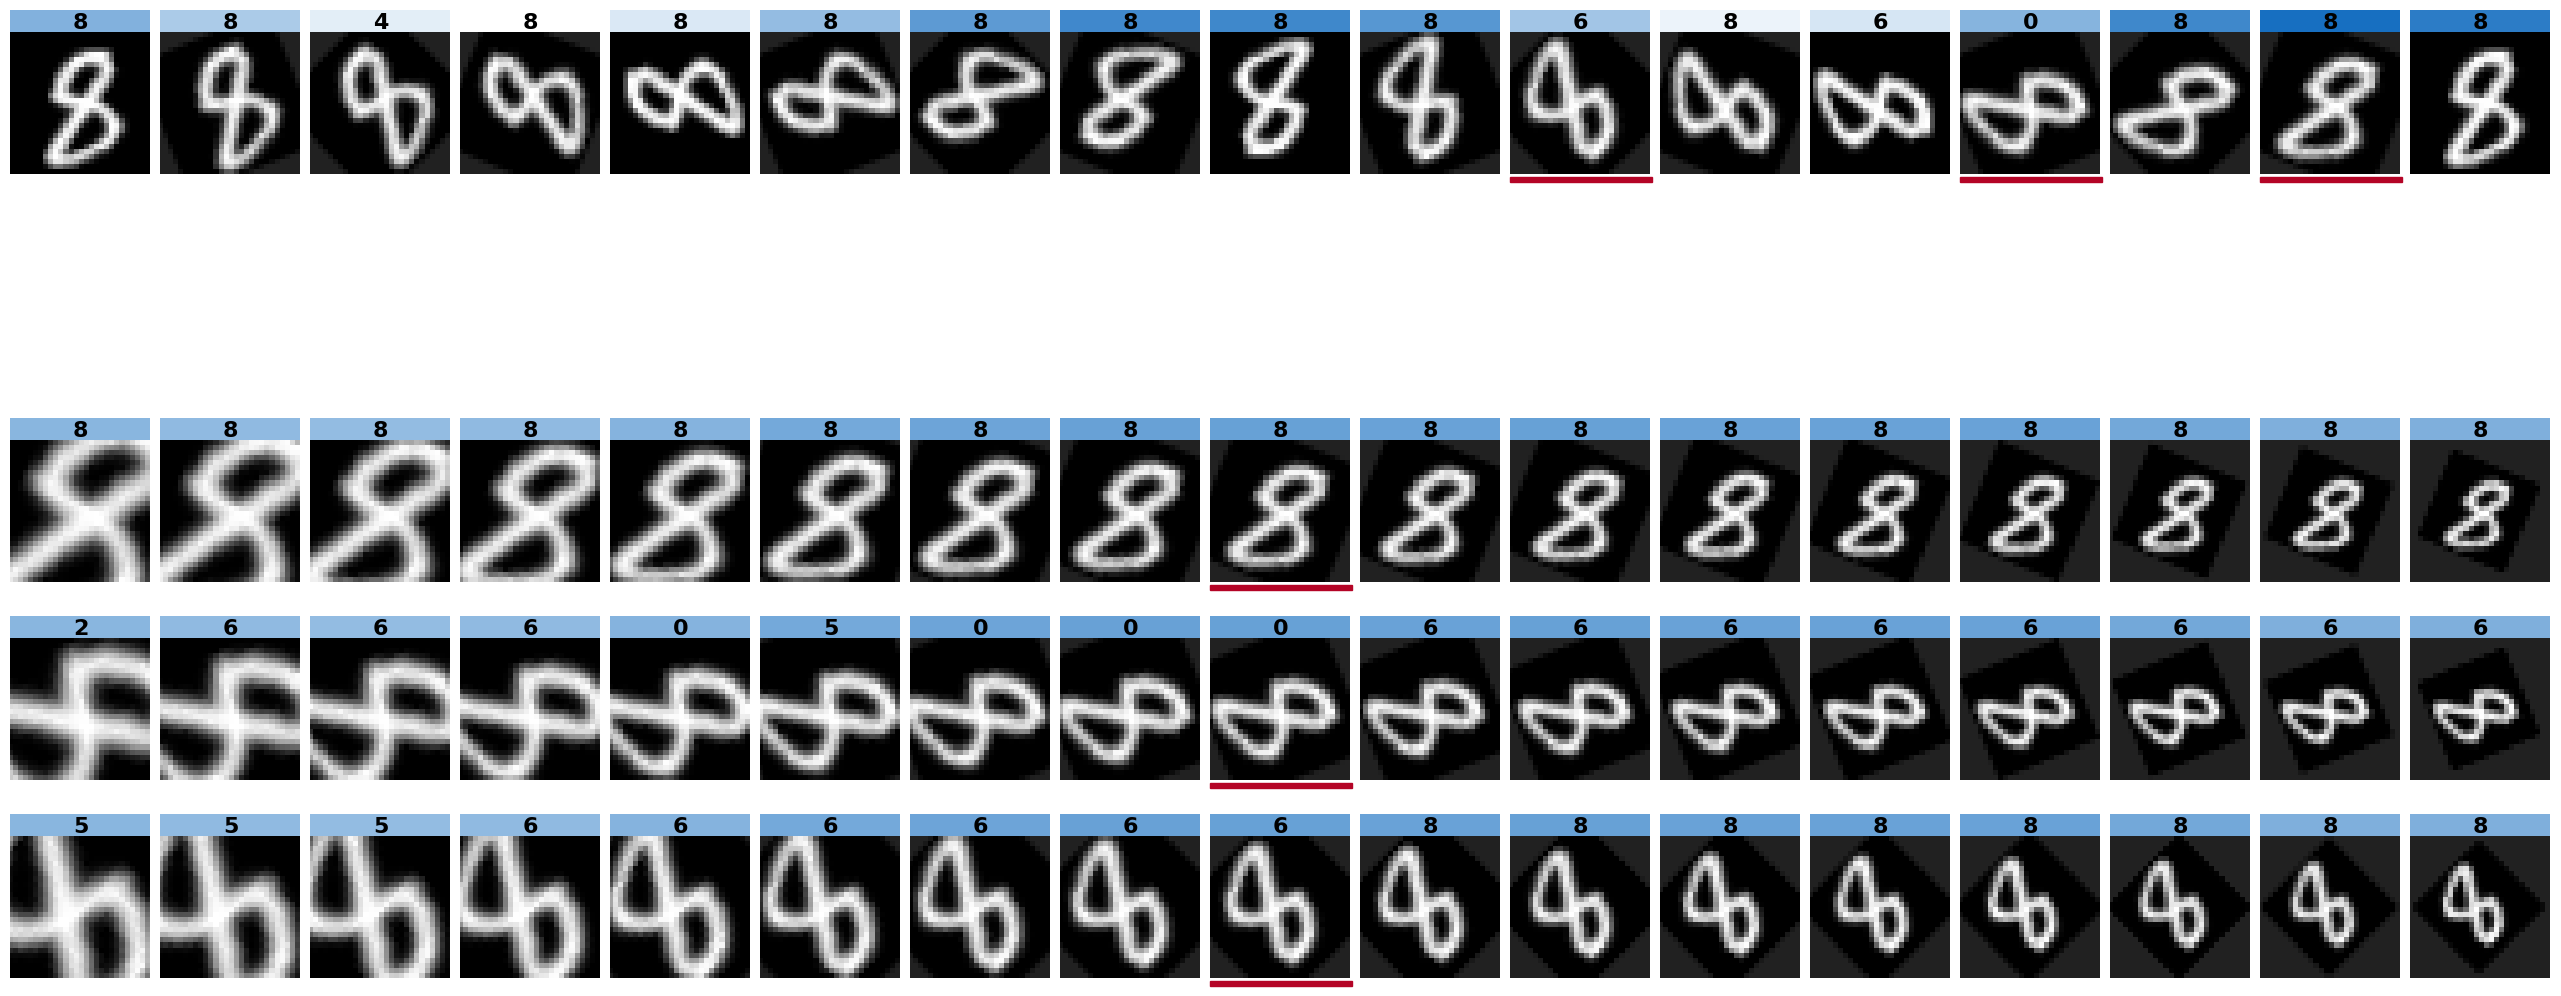

In [7]:
from src.search import InverseTransformationSearch

its = InverseTransformationSearch(model, transformation=transformations, domain=domains,
                                  n_samples=17, n_hypotheses=3, mc_steps=10,
                                  change_of_mind='score', en_unique_class_condition=True)

model.eval()
test_acc = 0
for d, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    data_canonic, embedding = its.infer(data, plot_idx=0 if d==0 else None)
    # pick the class of the leading hypothesis
    output = embedding.argmax(dim=-1)[:, 0]
    test_acc += output.eq(target).sum().item()
test_acc /= len(test_set)
print(f'Mean accuracy on the transformed test set [but with ITS]: {test_acc}.')

## Visualise the canonical forms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421302..2.821487].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421302..2.821487].


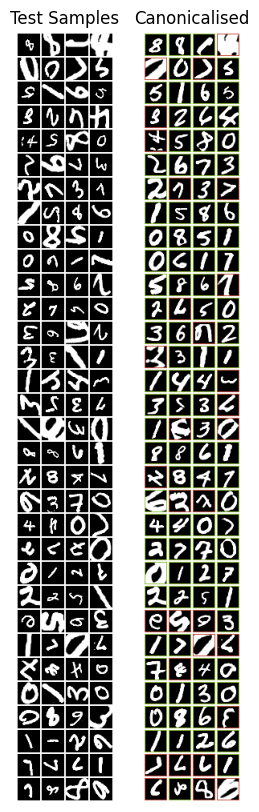

In [8]:
data, target = next(iter(test_loader))
data_canonic, embedding = its.infer(data.cuda())
output = embedding.argmax(dim=-1)[:, 0]
correct_label = output.eq(target.cuda())

# highlight correct predictions with green frame
green = torch.tensor((143, 194, 62))[:, None] / 255.
red = torch.tensor((194, 80, 62))[:, None] / 255.
data_canonic = data_canonic[:, 0].repeat(1, 3, 1, 1)
for image, correct in zip(data_canonic, correct_label):
    color = green if correct else red
    image[:, :, 0] = color
    image[:, :, 27] = color
    image[:, 0, :] = color
    image[:, 27, :] = color

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(3, 10))

axs[0].imshow(torchvision.utils.make_grid(data.cpu(), nrow=4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[1].imshow(torchvision.utils.make_grid(data_canonic.cpu(), nrow=4, pad_value=1).permute(1, 2, 0))

axs[0].set_title('Test Samples')
axs[1].set_title('Canonicalised')

for ax in axs.flat:
    ax.axis('off')